In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.cuda.amp import autocast, GradScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import random
import glob
import cv2
import os
from torchvision.models.video import r3d_18
import torchvision
import ast  

In [3]:
def extract_frames(video_path, output_folder, num_frames=16):
    os.makedirs(output_folder, exist_ok=True)
    
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frame_indices = [int(i * total_frames / num_frames) for i in range(num_frames)]
    count = 0
    
    for i in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        if i in frame_indices:
            frame_filename = os.path.join(output_folder, f"frame_{count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            count += 1
    
    cap.release()

extract_frames("dog_video.mp4", "output_frames", num_frames=16)


Відео dog_video.mp4 містить менше 16 кадрів!


In [4]:
input_folder = "/kaggle/input/dogs-pose/data"  
output_folder = "frames_dataset"

for category in os.listdir(input_folder):
    category_path = os.path.join(input_folder, category)
    
    if not os.path.isdir(category_path):
        continue  
    
    for subcategory in os.listdir(category_path):
        subcategory_path = os.path.join(category_path, subcategory)
        output_subfolder = os.path.join(output_folder, category, subcategory)
        
        os.makedirs(output_subfolder, exist_ok=True)
        
        for video_file in glob.glob(os.path.join(subcategory_path, "*.mp4")):
            video_name = os.path.splitext(os.path.basename(video_file))[0]
            extract_frames(video_file, os.path.join(output_subfolder, video_name), num_frames=16)


In [28]:
import os
import pandas as pd

def create_annotation_file(frames_root="/kaggle/working/frames_dataset", output_csv="/kaggle/working/train.csv"):
    data = []
    
    for category in os.listdir(frames_root):  
        category_path = os.path.join(frames_root, category)
        if not os.path.isdir(category_path):
            continue
        
        for subcategory in os.listdir(category_path):  
            subcategory_path = os.path.join(category_path, subcategory)
            if not os.path.isdir(subcategory_path):
                continue
            
            for video_folder in os.listdir(subcategory_path):  
                video_folder_path = os.path.join(subcategory_path, video_folder)
                frames = sorted(os.listdir(video_folder_path)) 
                frame_paths = [os.path.join(video_folder_path, frame) for frame in frames]
                
                if len(frame_paths) > 0:
                    data.append([frame_paths, category])  

    df = pd.DataFrame(data, columns=["frames", "label"])
    df.to_csv(output_csv, index=False)

create_annotation_file("frames_dataset", "train.csv")

In [29]:
data = pd.read_csv("/kaggle/working/train.csv")

In [30]:
class VideoFrameDataset(Dataset):
    def __init__(self, csv_file, transform=None, num_frames=16):
        self.data = pd.read_csv('/kaggle/working/train.csv')
        self.transform = transform
        self.num_frames = num_frames
        self.classes = sorted(self.data["label"].unique())  
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        frame_paths = ast.literal_eval(row["frames"])  
        label = self.class_to_idx[row["label"]]

        if len(frame_paths) >= self.num_frames:
            selected_frames = frame_paths[::len(frame_paths) // self.num_frames][:self.num_frames]
        else:
            selected_frames = frame_paths + [frame_paths[-1]] * (self.num_frames - len(frame_paths))  

        images = [Image.open(frame).convert("RGB") for frame in selected_frames]
        
        if self.transform:
            images = [self.transform(img) for img in images]

        return torch.stack(images), torch.tensor(label)


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])

])

train_data, temp_data = train_test_split(data, test_size=0.25)
valid_data, test_data = train_test_split(temp_data, test_size=0.25)

train_dataset = VideoFrameDataset("train.csv", transform=train_transforms, num_frames=8)
valid_dataset = VideoFrameDataset("valid.csv", transform=train_transforms, num_frames=8)
test_dataset = VideoFrameDataset("test.csv",transform=transform, num_frames=8)

frames, label = train_dataset[0]
print(frames.shape) 
print(label)  


torch.Size([8, 3, 224, 224])
tensor(0)


In [31]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

for batch in train_dataloader:
    frames, labels = batch
    print(frames.shape)  
    print(labels)
    break

torch.Size([8, 8, 3, 224, 224])
tensor([3, 3, 3, 0, 2, 2, 3, 3])


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNN_LSTM(nn.Module):
    def __init__(self, num_classes, hidden_size=256, num_layers=1):
        super(CNN_LSTM, self).__init__()

        resnet = models.resnet18(pretrained=True)
        resnet.fc = nn.Identity()  
        self.cnn = resnet

        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.shape

        x = x.view(batch_size * seq_len, C, H, W)

        x = self.cnn(x)  

        x = x.view(batch_size, seq_len, -1)

        x, _ = self.lstm(x)

        x = x[:, -1, :]

        x = self.fc(x)
        
        return x

model = CNN_LSTM(num_classes=4).to(device)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

In [36]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [37]:
num_epochs = 30 
scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    train_loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for frames, labels in train_loop:
        frames, labels = frames.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(frames)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        train_loop.set_postfix(loss=loss.item(), accuracy=100 * train_correct / train_total)
    
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * train_correct / train_total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    torch.cuda.empty_cache()  

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for frames, labels in valid_dataloader:
            frames, labels = frames.to(device), labels.to(device)
            with autocast():
                outputs = model(frames)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(valid_dataloader)
    val_accuracy = 100 * val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_loss)
    lr = scheduler.get_last_lr()

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

<ipython-input-37-c6751f1ad76f>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/30:   0%|          | 0/79 [00:00<?, ?it/s]<ipython-input-37-c6751f1ad76f>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/30: 100%|██████████| 79/79 [01:04<00:00,  1.23it/s, accuracy=68.8, loss=1.72] 
<ipython-input-37-c6751f1ad76f>:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/30: Train Loss: 0.8755, Train Acc: 68.85% | Val Loss: 0.7363, Val Acc: 69.65%


Epoch 2/30: 100%|██████████| 79/79 [01:06<00:00,  1.20it/s, accuracy=71.1, loss=1.63] 


Epoch 2/30: Train Loss: 0.7353, Train Acc: 71.09% | Val Loss: 0.5661, Val Acc: 78.27%


Epoch 3/30: 100%|██████████| 79/79 [01:05<00:00,  1.21it/s, accuracy=77.3, loss=0.0851]


Epoch 3/30: Train Loss: 0.5958, Train Acc: 77.32% | Val Loss: 0.5458, Val Acc: 77.16%


Epoch 4/30: 100%|██████████| 79/79 [01:06<00:00,  1.19it/s, accuracy=79.7, loss=1.52] 


Epoch 4/30: Train Loss: 0.5502, Train Acc: 79.71% | Val Loss: 0.5247, Val Acc: 77.48%


Epoch 5/30: 100%|██████████| 79/79 [01:05<00:00,  1.20it/s, accuracy=80.8, loss=0.355]


Epoch 5/30: Train Loss: 0.4863, Train Acc: 80.83% | Val Loss: 0.3845, Val Acc: 83.07%


Epoch 6/30: 100%|██████████| 79/79 [01:07<00:00,  1.17it/s, accuracy=86.1, loss=0.0608]


Epoch 6/30: Train Loss: 0.3524, Train Acc: 86.10% | Val Loss: 0.2608, Val Acc: 90.73%


Epoch 7/30: 100%|██████████| 79/79 [01:06<00:00,  1.19it/s, accuracy=88, loss=0.82]    


Epoch 7/30: Train Loss: 0.3269, Train Acc: 88.02% | Val Loss: 0.1874, Val Acc: 93.77%


Epoch 8/30: 100%|██████████| 79/79 [01:06<00:00,  1.18it/s, accuracy=89.1, loss=0.508] 


Epoch 8/30: Train Loss: 0.2643, Train Acc: 89.14% | Val Loss: 0.2351, Val Acc: 92.33%


Epoch 9/30: 100%|██████████| 79/79 [01:05<00:00,  1.20it/s, accuracy=92.8, loss=0.144] 


Epoch 9/30: Train Loss: 0.2110, Train Acc: 92.81% | Val Loss: 0.1375, Val Acc: 94.73%


Epoch 10/30: 100%|██████████| 79/79 [01:05<00:00,  1.20it/s, accuracy=94.9, loss=0.0296]


Epoch 10/30: Train Loss: 0.1404, Train Acc: 94.89% | Val Loss: 0.1003, Val Acc: 96.65%


Epoch 11/30: 100%|██████████| 79/79 [01:07<00:00,  1.17it/s, accuracy=95.8, loss=0.0272]


Epoch 11/30: Train Loss: 0.1275, Train Acc: 95.85% | Val Loss: 0.0917, Val Acc: 96.65%


Epoch 12/30: 100%|██████████| 79/79 [01:07<00:00,  1.18it/s, accuracy=94.9, loss=0.0102]


Epoch 12/30: Train Loss: 0.1249, Train Acc: 94.89% | Val Loss: 0.0795, Val Acc: 97.92%


Epoch 13/30: 100%|██████████| 79/79 [01:06<00:00,  1.19it/s, accuracy=95.7, loss=0.0247] 


Epoch 13/30: Train Loss: 0.1159, Train Acc: 95.69% | Val Loss: 0.0675, Val Acc: 97.60%


Epoch 14/30: 100%|██████████| 79/79 [01:05<00:00,  1.20it/s, accuracy=97, loss=2.64]     


Epoch 14/30: Train Loss: 0.1349, Train Acc: 96.96% | Val Loss: 0.0616, Val Acc: 97.76%


Epoch 15/30: 100%|██████████| 79/79 [01:06<00:00,  1.19it/s, accuracy=97.1, loss=0.0221] 


Epoch 15/30: Train Loss: 0.0824, Train Acc: 97.12% | Val Loss: 0.0570, Val Acc: 98.24%


Epoch 16/30: 100%|██████████| 79/79 [01:06<00:00,  1.19it/s, accuracy=97.1, loss=0.0192]


Epoch 16/30: Train Loss: 0.0850, Train Acc: 97.12% | Val Loss: 0.0539, Val Acc: 98.56%


Epoch 17/30: 100%|██████████| 79/79 [01:06<00:00,  1.19it/s, accuracy=97.9, loss=0.118]  


Epoch 17/30: Train Loss: 0.0644, Train Acc: 97.92% | Val Loss: 0.0395, Val Acc: 99.04%


Epoch 18/30: 100%|██████████| 79/79 [01:06<00:00,  1.19it/s, accuracy=97.6, loss=0.019]  


Epoch 18/30: Train Loss: 0.0707, Train Acc: 97.60% | Val Loss: 0.0396, Val Acc: 99.04%


Epoch 19/30: 100%|██████████| 79/79 [01:06<00:00,  1.19it/s, accuracy=98.1, loss=1.76]   


Epoch 19/30: Train Loss: 0.0820, Train Acc: 98.08% | Val Loss: 0.0391, Val Acc: 99.20%


Epoch 20/30: 100%|██████████| 79/79 [01:07<00:00,  1.17it/s, accuracy=98.2, loss=0.0155] 


Epoch 20/30: Train Loss: 0.0560, Train Acc: 98.24% | Val Loss: 0.0364, Val Acc: 99.20%


Epoch 21/30: 100%|██████████| 79/79 [01:06<00:00,  1.19it/s, accuracy=97.4, loss=0.0273] 


Epoch 21/30: Train Loss: 0.0662, Train Acc: 97.44% | Val Loss: 0.0330, Val Acc: 99.20%


Epoch 22/30: 100%|██████████| 79/79 [01:07<00:00,  1.18it/s, accuracy=99.2, loss=0.017]  


Epoch 22/30: Train Loss: 0.0372, Train Acc: 99.20% | Val Loss: 0.0331, Val Acc: 99.04%


Epoch 23/30: 100%|██████████| 79/79 [01:06<00:00,  1.19it/s, accuracy=98.7, loss=0.0447] 


Epoch 23/30: Train Loss: 0.0439, Train Acc: 98.72% | Val Loss: 0.0326, Val Acc: 99.20%


Epoch 24/30: 100%|██████████| 79/79 [01:06<00:00,  1.19it/s, accuracy=98.6, loss=0.0131] 


Epoch 24/30: Train Loss: 0.0671, Train Acc: 98.56% | Val Loss: 0.0313, Val Acc: 99.20%


Epoch 25/30: 100%|██████████| 79/79 [01:06<00:00,  1.19it/s, accuracy=98.6, loss=0.03]   


Epoch 25/30: Train Loss: 0.0530, Train Acc: 98.56% | Val Loss: 0.0345, Val Acc: 99.04%


Epoch 26/30: 100%|██████████| 79/79 [01:06<00:00,  1.19it/s, accuracy=99, loss=0.00739]  


Epoch 26/30: Train Loss: 0.0446, Train Acc: 99.04% | Val Loss: 0.0322, Val Acc: 99.04%


Epoch 27/30: 100%|██████████| 79/79 [01:06<00:00,  1.18it/s, accuracy=98.7, loss=0.00862]


Epoch 27/30: Train Loss: 0.0477, Train Acc: 98.72% | Val Loss: 0.0338, Val Acc: 98.88%


Epoch 28/30: 100%|██████████| 79/79 [01:06<00:00,  1.18it/s, accuracy=98.7, loss=3.84]   


Epoch 28/30: Train Loss: 0.0936, Train Acc: 98.72% | Val Loss: 0.0299, Val Acc: 99.20%


Epoch 29/30:   0%|          | 0/79 [00:02<?, ?it/s]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Training and Validation Loss')

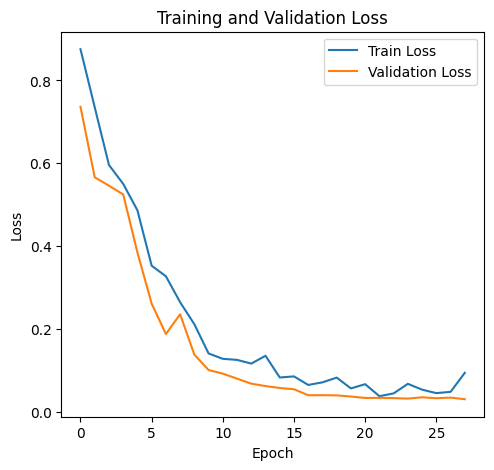

In [38]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

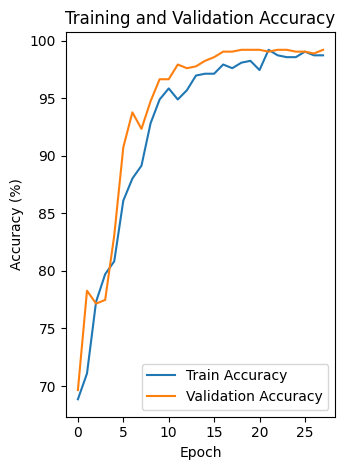

In [40]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [41]:
def evaluate(model, test_loader):
    model.eval()  
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():  
        for frames, labels in test_loader:
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)  
            _, predicted = torch.max(outputs, 1)  

            total += labels.size(0)  
            correct += (predicted == labels).sum().item()

            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

    accuracy = 100 * correct / total
    return accuracy, torch.cat(all_preds), torch.cat(all_labels)

accuracy, all_preds, all_labels = evaluate(model, test_dataloader)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 98.24%


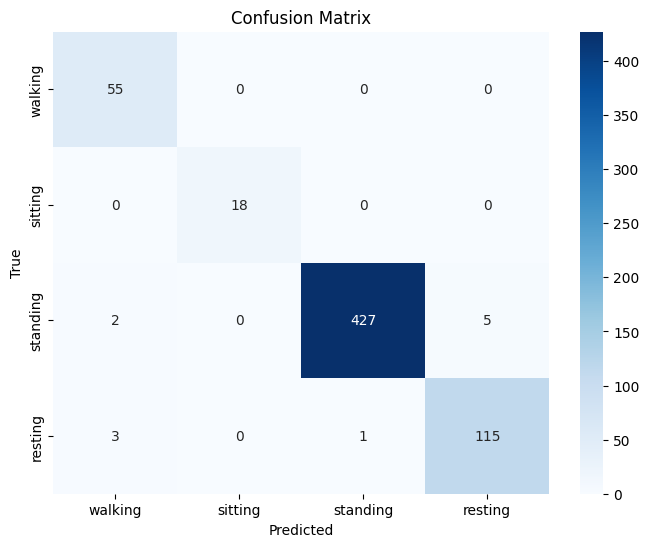

In [42]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["walking", "sitting", "standing", "resting"], yticklabels=["walking", "sitting", "standing", "resting"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [43]:
model_path = "dog_pose_model_best_advanced.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, model_path)
print(f"Модель збережена у {model_path}")

Модель збережена у dog_pose_model_best_adv_5.pth
